In [3]:

import logging
from pathlib import Path

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from accelerate import Accelerator
import tensorflow as tf



2023-07-15 00:34:25.758875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 00:34:26.559892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from datasets import load_dataset

In [6]:
from torch.utils.data.dataloader import DataLoader

In [7]:
from torch.utils.data import IterableDataset

In [ ]:
class ConstantLengthDataset(IterableDataset):
    def __init__(self, tokenizer, dataset, field, seq_length=1024, num_of_sequences=1024, chars_per_token=3.6):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.bos_token_id
        self.dataset = dataset
        self.seq_length = seq_length
        self.input_characters = seq_length * chars_per_token * num_of_sequences
        self.field=field

    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.input_characters:
                    break
                try:
                    buffer.append(next(iterator)[self.field])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    more_examples = False
                    break
            tokenized_inputs = self.tokenizer(buffer, truncation=False)["input_ids"]
            all_token_ids = []
            for tokenized_input in tokenized_inputs:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    yield torch.tensor(input_ids)

In [ ]:
def create_dataloader(args,tokenizer):
    data_files  = {"test":args['test_bed_name']}
    valid_data = load_dataset(args['data_path'], data_files=data_files, split="test")
    valid_dataset = ConstantLengthDataset(tokenizer, valid_data, args['field'], seq_length=args['seq_length'])
    eval_dataloader = DataLoader(valid_dataset, batch_size=args['batch_size'])
    return  eval_dataloader

In [ ]:
def evaluate(args,model,eval_dataloader):
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch, labels=batch)
        loss = outputs.loss.repeat(args['batch_size'])
        losses.append(accelerator.gather(loss))

        if args['max_eval_steps'] > 0 and step >= args['max_eval_steps']:
            break
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()




In [ ]:
def param_default():
    model_name = 'codeparrot-small' #<-- Scope
    test_bed_name='code_completion_random_cut_5k_30_512_tokens.json'
    semeru_datases_path= '/workspaces/code-rationales/'
    data_path = Path(semeru_datases_path+'datax/' + model_name + '/')
    data_path= semeru_datases_path+'semeru-datasets/semeru/galeras/code_rationales'
    #data_path_raw = Path('../athena-datasets/' + corpus + '/raw/')
    #tokenizer_path = Path('../tokenizer/')
    return {
        'out_processed' : '/datasets/out_processed/',
        'checkpoint_file': Path(semeru_datases_path+'data/codeparrot-small/checkpoints/checkpoint-29000'), #Model
        'output_results' : 'results/' ,
        'seed': 1,
        'data_path': data_path,
        'test_bed_name':test_bed_name,
        'seq_length': 64,
        'batch_size': 2,
        'field': "random_cut",
        'max_eval_steps':-1
    }

In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

In [ ]:
torch.cuda.memory_allocated()

In [ ]:
# Setup Accelerator
accelerator = Accelerator()
params = param_default()
# Parse configuration
set_seed(params['seed'])

# Logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO
)

# Load model and tokenizer
checkpoint = params['checkpoint_file']
model = AutoModelForCausalLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = model.to( device ) #WARNING, Verify the device before assigning to memory

# Load dataset and dataloader
valid_dataset, eval_dataloader = create_dataloader(params,tokenizer)

# Prepare everything with our `accelerator`.
model, valid_dataset, eval_dataloader = accelerator.prepare(model, valid_dataset, eval_dataloader)

# Evaluate and save the last checkpoint
logger.info("Evaluating and saving model after training")
eval_loss, perplexity = evaluate(params, model, eval_dataloader)
logger.info(f"loss/eval: {eval_loss}, perplexity: {perplexity}")

## Naive test for code completion

In [ ]:
#device ="cpu"

In [ ]:
prompt ="def duntion_test():"
prompt="def test_frequency_condition_alone(self):\n        prev_hour = timezone.now() - timedelta(hours=1)"
params = param_default()

#torch.manual_seed(0)
model = AutoModelForCausalLM.from_pretrained(params['checkpoint_file'])
tokenizer = AutoTokenizer.from_pretrained(params['checkpoint_file'])
model = model.to( device ) #WARNING, Verify the device before assigning to memory
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
outputs = model.generate(input_ids, do_sample=True, max_length=128)

tokenizer.batch_decode(outputs, skip_special_tokens=True)


## Outcome generation & Levenshtein evaluation

In [ ]:
## This iterator is NOT working for batches > 1!!

class ConstantTokenLengthDataset(IterableDataset):
    def __init__(self, tokenizer, dataset, field, num_of_tokens=64, num_of_sequences=1024):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.num_of_tokens = min(num_of_tokens, tokenizer.model_max_length)
        self.field=field
        self.input_char = int(self.num_of_tokens*3.6)
        self.num_of_sequences=num_of_sequences
        self.prompts=[]

    def __iter__(self):  
        for i, buffer in enumerate(self.dataset):
            size = min(len(buffer[self.field]),self.input_char)
            input = buffer[self.field][:size]
            self.prompts.append(input)
            if i > self.num_of_sequences:
                break
        tokenized_inputs = self.tokenizer(self.prompts, max_length= self.num_of_tokens, padding=True, truncation=True, return_tensors="pt")["input_ids"]
        for tokenized_input in tokenized_inputs:
            yield torch.tensor(tokenized_input)

In [ ]:
def create_dataloader(args,tokenizer):
    data_files  = {"test":args['test_bed_name']}
    valid_data = load_dataset(args['data_path'], data_files=data_files, split="test")
    valid_dataset = ConstantTokenLengthDataset(tokenizer, valid_data, args['field'], num_of_tokens=args['seq_length'])
    eval_dataloader = DataLoader(valid_dataset, batch_size=1)
    return  valid_dataset, eval_dataloader

In [ ]:
def generate_outcomes(args,model,eval_dataloader,valid_data):
    model.eval()
    results = []
    for step, inputs in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model.generate(inputs, do_sample=True, max_length=128,  pad_token_id=tokenizer.eos_token_id)
            outcome = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        prompt=valid_data.prompts[step]
        result = {"prompt": prompt, "outcome":outcome}
        results.append(result)
        if args['max_eval_steps'] > 0 and step >= args['max_eval_steps']:
            break
    return results


In [ ]:
# Setup Accelerator
accelerator = Accelerator()
params = param_default()
# Parse configuration
set_seed(params['seed'])

# Logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO
)

# Load model and tokenizer
checkpoint = params['checkpoint_file']
model = AutoModelForCausalLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token
model = model.to( device ) #WARNING, Verify the device before assigning to memory

# Load dataset and dataloader
valid_dataset, eval_dataloader = create_dataloader(params,tokenizer)

# Prepare everything with our `accelerator`.
model, valid_dataset, eval_dataloader = accelerator.prepare(model, valid_dataset, eval_dataloader)

# Evaluate and save the last checkpoint
logger.info("Evaluating and saving model after training")
outcomes = generate_outcomes(params, model, eval_dataloader,valid_dataset)
logger.info(f"outomces: {len(outcomes)}")

In [ ]:
outcomes

In [45]:
import pandas as pd
import textdistance

In [ ]:
levenshtein_similarity = textdistance.levenshtein


In [ ]:
lev_calc = [levenshtein_similarity.normalized_similarity(x["prompt"].strip(), x["outcome"][0].strip() ) for x in outcomes]


In [ ]:
df = pd.DataFrame(outcomes)
df = df.assign(lev_sim=lev_calc)

In [ ]:
df.describe()

## Evaluation model from samples

In [8]:
import pandas as pd
import textdistance
import ast

In [9]:
path = "/workspaces/code-rationales/data/sampling/gpt/code_completion_docstring_5k_30_150_tokens.csv"

In [10]:
df = pd.read_csv(path, index_col=0)

In [11]:
df.head()

,index,prompt,ground_truth,size,input_ids,0,1,2,3,4,...,20,21,22,23,24,25,26,27,28,29
0,0,Generate Pyhton code that Check if the grid cl...,Check if the grid client is up.\n\n Check f...,42,"[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...",...,"[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3...","[6864, 1611, 517, 265, 1233, 626, 2670, 340, 3..."
1,1,Generate Pyhton code that Ensure that powershe...,\n Ensure that powershell processes inl...,142,"[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...",...,"[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7...","[6864, 1611, 517, 265, 1233, 626, 7523, 626, 7..."
2,2,Generate Pyhton code that Encode a bytestring ...,\n Encode a bytestring to a base64 string f...,59,"[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...",...,"[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ...","[6864, 1611, 517, 265, 1233, 626, 19244, 282, ..."
3,3,Generate Pyhton code that Add the arguments fo...,Add the arguments for the protocol to the clie...,97,"[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...",...,"[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2...","[6864, 1611, 517, 265, 1233, 626, 2654, 314, 2..."
4,4,Generate Pyhton code that Locking should inclu...,Locking should include hashes for *all* platf...,60,"[6864, 1611, 517, 265, 1233, 626, 15536, 316, .

In [12]:
df.shape

(100, 35)

In [13]:
def param_default():
    model_name = 'codeparrot-small' #<-- Model
    test_bed_name= 'code_completion_docstring_5k_30_150_tokens.csv'
    datasets_path= Path('/workspaces/code-rationales')
    datax = Path(datasets_path/'datax')
    data = Path(datasets_path/'data')
    galeras_sampling= Path(data/ 'sampling/gpt')
    model_path='codeparrot-small/checkpoints/checkpoint-29000'
    return {
        'out_processed' : '/datasets/out_processed/',
        'checkpoint_file': str(Path(data/model_path)), #Model
        'output_results' : 'results/' ,
        'seed': 1,
        'data_path': str(Path(galeras_sampling/test_bed_name)),
        'test_bed_name':test_bed_name,
        'seq_length': 64,
        'batch_size': 2,
        'field': "random_cut",
        'max_eval_steps':-1
    }

In [14]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
device = "cpu"

In [17]:
torch.device(device)

device(type='cpu')

In [18]:
accelerator = Accelerator()
params = param_default()
# Parse configuration
set_seed(params['seed'])

# Logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO
)

# Load model and tokenizer
checkpoint = params['checkpoint_file']
model = AutoModelForCausalLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#tokenizer.pad_token = tokenizer.eos_token
model = model.to( device ) #WARNING, Verify the device before assigning to memory

# Prepare everything with our `accelerator`.
model = accelerator.prepare(model)



In [19]:
levenshtein_similarity = textdistance.levenshtein


In [20]:
def convert_df_string_to_array(df,column):
    try : 
        df[column] = df[column].apply(ast.literal_eval)
    except:
        logger.warning("Not column convertion from string to array")
    finally:
        return df

In [29]:
def compute_levenshtein_from_samples(tokenizer, df, samples= 30):
    outcomes_df = pd.DataFrame()
    lev_columns = []
    for i in range(0,samples):
        with torch.no_grad():
            df = convert_df_string_to_array(df, str(i))
            outcomes = tokenizer.batch_decode(df[str(i)].to_list(), skip_special_tokens=True)
            outcomes_df['outcome_'+str(i)] = outcomes
            col_name = 'lev_'+str(i)
            lev_columns.append(col_name)
            outcomes_df[col_name] = [levenshtein_similarity.normalized_similarity(x.strip(), df['ground_truth'][step].strip() ) for step,x in enumerate(outcomes)]
            logger.info("computed levenshtein for outome " + str(i))               

    outcomes_df['avg_lev'] = outcomes_df[lev_columns].mean(axis=1)
    outcomes_df['std_lev'] = outcomes_df[lev_columns].std(axis=1)
    return outcomes_df
            

In [22]:
# Compute levenshtein for each outcome and the average
path = "/workspaces/code-rationales/data/sampling/gpt/code_completion_docstring_5k_30_150_tokens.csv"
df = pd.read_csv(path, index_col=0)
logger.info("Evaluating and saving model after training")
lev_df = compute_levenshtein_from_samples(tokenizer, df, 30)
logger.info(f"outomces: {len(lev_df.shape)}")

07/15/2023 00:36:34 - INFO - __main__ - Evaluating and saving model after training
07/15/2023 00:36:51 - INFO - __main__ - computed levenshtein for outome 0
07/15/2023 00:37:07 - INFO - __main__ - computed levenshtein for outome 1
07/15/2023 00:37:24 - INFO - __main__ - computed levenshtein for outome 2
07/15/2023 00:37:40 - INFO - __main__ - computed levenshtein for outome 3
07/15/2023 00:37:57 - INFO - __main__ - computed levenshtein for outome 4
07/15/2023 00:38:13 - INFO - __main__ - computed levenshtein for outome 5
07/15/2023 00:38:30 - INFO - __main__ - computed levenshtein for outome 6
07/15/2023 00:38:46 - INFO - __main__ - computed levenshtein for outome 7
07/15/2023 00:39:02 - INFO - __main__ - computed levenshtein for outome 8
07/15/2023 00:39:19 - INFO - __main__ - computed levenshtein for outome 9
07/15/2023 00:39:35 - INFO - __main__ - computed levenshtein for outome 10
07/15/2023 00:39:52 - INFO - __main__ - computed levenshtein for outome 11
07/15/2023 00:40:08 - INFO 

In [23]:
lev_df.head()

,outcome_0,lev_0,outcome_1,lev_1,outcome_2,lev_2,outcome_3,lev_3,outcome_4,lev_4,...,lev_25,outcome_26,lev_26,outcome_27,lev_27,outcome_28,lev_28,outcome_29,lev_29,avg_lev
0,Generate Pyhton code that Check if the grid cl...,0.224626,Generate Pyhton code that Check if the grid cl...,0.192362,Generate Pyhton code that Check if the grid cl...,0.243636,Generate Pyhton code that Check if the grid cl...,0.227273,Generate Pyhton code that Check if the grid cl...,0.224252,...,0.222586,Generate Pyhton code that Check if the grid cl...,0.217252,Generate Pyhton code that Check if the grid cl...,0.245931,Generate Pyhton code that Check if the grid cl...,0.241071,Generate Pyhton code that Check if the grid cl...,0.198839,0.226278
1,Generate Pyhton code that Ensure that powershe...,0.322621,Generate Pyhton code that Ensure that powershe...,0.326347,Generate Pyhton code that Ensure that powershe...,0.325524,Generate Pyhton code that Ensure that powershe...,0.327132,Generate Pyhton code that Ensure that powershe...,0.275387,...,0.345768,Generate Pyhton code that Ensure that powershe...,0.326271,Generate Pyhton code that Ensure that powershe...,0.364109,Generate Pyhton code that Ensure that powershe...,0.331646,Generate Pyhton code that Ensure that powershe...,0.306836,0.314065
2,Generate Pyhton code that Encode a bytestring ...,0.257911,Generate Pyhton code that Encode a bytestring ...,0.255556,Generate Pyhton code that Encode a bytestring ...,0.258224,Generate Pyhton code that Encode a bytestring ...,0.275510,Generate Pyhton code that Encode a bytestring ...,0.216366,...,0.227596,Generate Pyhton code that Encode a bytestring ...,0.253756,Generate Pyhton code that Encode a bytestring ...,0.224818,Generate Pyhton code that Encode a bytestring ...,0.229412,Generate Pyhton code that Encode a bytestring ...,0.260450,0.237612
3,Generate Pyhton code that Add the arguments fo...,0.328746,Generate Pyhton code that Add the arguments fo...,0.326996,Generate Pyhton code that Add the arguments fo...,0.343606,Generate Pyhton code that Add the arguments fo...,0.333333,Generate Pyhton code that Add the arguments fo...,0.357250,...,0.385366,Generate Pyhton code that Add the arguments fo...,0.316712,Generate Pyhton code that Add the arguments fo...,0.334405,Generate Pyhton code that Add the arguments fo...,0.325581,Generate Pyhton code that Add the arguments fo...,0.343548,0.336747
4,Generate Pyhton code that Locking should inclu...,0.248555,Generate Pyhton code that Locking should inclu...,0.254360,Generate Pyhton code that Locking should inclu...,0.257576,Generate Pyhton code that Locking should inclu...,0.273921,Generate Pyhton code that Locking should inclu...,0.310592,...,0.269108,Generate Pyhton code that Locking should inclu...,0.262270,Generate Pyhton code that Locking should inclu...,0.262519,Generate Pyhton code that Locking should inclu...,0.275081,Generate Pyhton code that Locking should inclu...,0.227213,0.258122


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Codeparrot docstring - AVG Levenshtein - 30 samples')

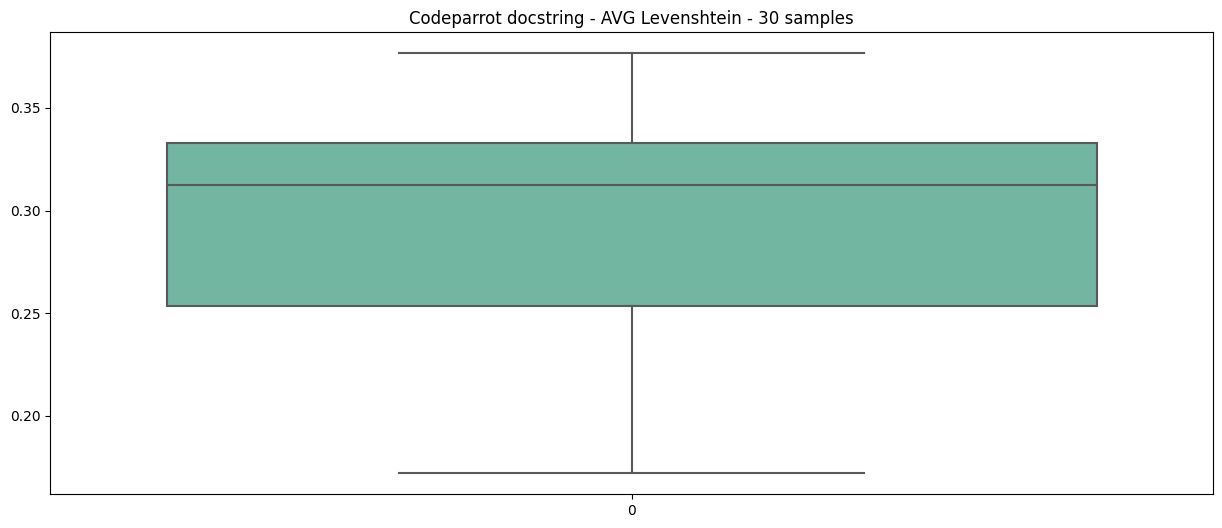

In [91]:
plt.figure(figsize=(15, 6)) 
sns.boxplot(data=lev_df["avg_lev"], showfliers=False,palette="Set2").set_title("Codeparrot docstring - AVG Levenshtein - 30 samples")

### Docstring & random cut

In [24]:
path = "/workspaces/code-rationales/data/sampling/gpt/code_completion_docstring_random_cut_3.8k_30_150_tokens.csv"

In [25]:
random_cut_df = pd.read_csv(path, index_col=0)

In [26]:
random_cut_df.head()

,index,prompt,ground_truth,size,input_ids,0,1,2,3,4,...,20,21,22,23,24,25,26,27,28,29
0,0,Generate Pyhton code that Assert that the TPOT...,Assert that the TPOT CLI interface's positive_...,55,"[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...",...,"[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ...","[6864, 1611, 517, 265, 1233, 626, 10716, 626, ..."
1,1,Generate Pyhton code that \n Return the maj...,\n Return the major-minor version of the cu...,63,"[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...",...,"[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ...","[6864, 1611, 517, 265, 1233, 626, 5591, 1432, ..."
2,2,Generate Pyhton code that \n Encode a bytes...,\n Encode a bytestring to a base64 string f...,59,"[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...",...,"[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,...","[6864, 1611, 517, 265, 1233, 626, 5591, 19244,..."
3,3,Generate Pyhton code that Represents the numbe...,Represents the number as a triple tuple.\n\n ...,52,"[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...",...,"[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ...","[6864, 1611, 517, 265, 1233, 626, 21591, 314, ..."
4,4,Generate Pyhton code that \n Return the...,\n Return the context variables require...,47,"[6864, 1611, 517, 265, 1233, 626, 4960, 1432, ...","[6864, 16

In [27]:
# Compute levenshtein for each outcome and the average
logger.info("Evaluating and saving model after training")
lev_rand_df = compute_levenshtein_from_samples(tokenizer, random_cut_df, 30)
logger.info(f"outomces: {len(lev_rand_df.shape)}")

07/15/2023 00:44:50 - INFO - __main__ - Evaluating and saving model after training
07/15/2023 00:45:05 - INFO - __main__ - computed levenshtein for outome 0
07/15/2023 00:45:20 - INFO - __main__ - computed levenshtein for outome 1
07/15/2023 00:45:34 - INFO - __main__ - computed levenshtein for outome 2
07/15/2023 00:45:49 - INFO - __main__ - computed levenshtein for outome 3
07/15/2023 00:46:04 - INFO - __main__ - computed levenshtein for outome 4
07/15/2023 00:46:19 - INFO - __main__ - computed levenshtein for outome 5
07/15/2023 00:46:33 - INFO - __main__ - computed levenshtein for outome 6
07/15/2023 00:46:48 - INFO - __main__ - computed levenshtein for outome 7
07/15/2023 00:47:03 - INFO - __main__ - computed levenshtein for outome 8
07/15/2023 00:47:18 - INFO - __main__ - computed levenshtein for outome 9
07/15/2023 00:47:32 - INFO - __main__ - computed levenshtein for outome 10
07/15/2023 00:47:47 - INFO - __main__ - computed levenshtein for outome 11
07/15/2023 00:48:01 - INFO 

In [28]:
lev_rand_df

,outcome_0,lev_0,outcome_1,lev_1,outcome_2,lev_2,outcome_3,lev_3,outcome_4,lev_4,...,lev_25,outcome_26,lev_26,outcome_27,lev_27,outcome_28,lev_28,outcome_29,lev_29,avg_lev
0,Generate Pyhton code that Assert that the TPOT...,0.386266,Generate Pyhton code that Assert that the TPOT...,0.310855,Generate Pyhton code that Assert that the TPOT...,0.399554,Generate Pyhton code that Assert that the TPOT...,0.321368,Generate Pyhton code that Assert that the TPOT...,0.281481,...,0.361493,Generate Pyhton code that Assert that the TPOT...,0.364173,Generate Pyhton code that Assert that the TPOT...,0.332734,Generate Pyhton code that Assert that the TPOT...,0.352381,Generate Pyhton code that Assert that the TPOT...,0.333919,0.338288
1,Generate Pyhton code that \n Return the maj...,0.368000,Generate Pyhton code that \n Return the maj...,0.325581,Generate Pyhton code that \n Return the maj...,0.384454,Generate Pyhton code that \n Return the maj...,0.355422,Generate Pyhton code that \n Return the maj...,0.317949,...,0.329159,Generate Pyhton code that \n Return the maj...,0.309811,Generate Pyhton code that \n Return the maj...,0.332090,Generate Pyhton code that \n Return the maj...,0.427885,Generate Pyhton code that \n Return the maj...,0.369650,0.355154
2,Generate Pyhton code that \n Encode a bytes...,0.373134,Generate Pyhton code that \n Encode a bytes...,0.402414,Generate Pyhton code that \n Encode a bytes...,0.364299,Generate Pyhton code that \n Encode a bytes...,0.363636,Generate Pyhton code that \n Encode a bytes...,0.396040,...,0.359712,Generate Pyhton code that \n Encode a bytes...,0.364964,Generate Pyhton code that \n Encode a bytes...,0.421053,Generate Pyhton code that \n Encode a bytes...,0.362319,Generate Pyhton code that \n Encode a bytes...,0.391389,0.374835
3,Generate Pyhton code that Represents the numbe...,0.299248,Generate Pyhton code that Represents the numbe...,0.371917,Generate Pyhton code that Represents the numbe...,0.268362,Generate Pyhton code that Represents the numbe...,0.307692,Generate Pyhton code that Represents the numbe...,0.339100,...,0.271210,Generate Pyhton code that Represents the numbe...,0.379175,Generate Pyhton code that Represents the numbe...,0.331633,Generate Pyhton code that Represents the numbe...,0.330537,Generate Pyhton code that Represents the numbe...,0.318555,0.325785
4,Generate Pyhton code that \n Return the...,0.336052,Generate Pyhton code that \n Return the...,0.263298,Generate Pyhton code that \n Return the...,0.317230,Generate Pyhton code that \n Return the...,0.259067,Generate Pyhton code that \n Return the...,0.309985,...,0.272977,Generate Pyhton code that \n Return the...,0.303030,Generate Pyhton code that \n Return the...,0.298643,Generate Pyhton code that \n Return the...,0.290323,Generate Pyhton code that \n Return the...,0.290087,0.291958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Generate Pyhton code that List the locally-ava...,0.417742,Generate Pyhton code that List the locally-ava...,0.524096,Generate Pyhton code that List the locally-ava...,0.477064,Generate Pyhton code that List the locally-ava...,0.444062,Generate Pyhton code that List the locally-ava...,0.453427,...,0.431667,Generate Pyhton code that List the locally-ava...,0.514000,Generate Pyhton code that List the locally-ava...,0.535934,Generate Pyhton code that List the locally-ava...,0.392638,Generate Pyhton code that List the locally-ava...,0.438240,0.452329
96,Generate Pyhton code that Enable the proactive...,0.411581,Generate Pyhton code that Enable the proactive...,0.425081,Generate Pyhton code that Enable the proactive...,0.418941,Generate Pyhton code that Enable the proactive...,0.442761,Generate Pyhton code that Enable the proactive...,0.452055,...,0.437919,Generate Pyhton code that Enable the proactive...,0.431894,Generate Pyhton code that Enable the proactive...,0.415605,Generate Pyhton code that Enable the proactive...,0.464664,Generate Pyhton code that Enable the p

In [33]:
lev_means = pd.concat([lev_df['avg_lev'],lev_rand_df['avg_lev']], axis=1)

In [34]:
lev_means

,avg_lev,avg_lev
0,0.226278,0.338288
1,0.314065,0.355154
2,0.237612,0.374835
3,0.336747,0.325785
4,0.258122,0.291958
...,...,...
95,0.265501,0.452329
96,0.232252,0.429342
97,0.297307,0.392804
98,0.311582,0.418779


In [35]:
# Compute levenshtein for each outcome and the average
path = "/workspaces/code-rationales/data/sampling/gpt/code_completion_docstring_signature_3.8k_30_150_tokens.csv"
df = pd.read_csv(path, index_col=0)
logger.info("Evaluating and saving model after training")
lev_signature_df = compute_levenshtein_from_samples(tokenizer, df, 30)
logger.info(f"outomces: {len(lev_df.shape)}")

07/15/2023 01:22:24 - INFO - __main__ - Evaluating and saving model after training
07/15/2023 01:22:39 - INFO - __main__ - computed levenshtein for outome 0
07/15/2023 01:22:54 - INFO - __main__ - computed levenshtein for outome 1
07/15/2023 01:23:09 - INFO - __main__ - computed levenshtein for outome 2
07/15/2023 01:23:24 - INFO - __main__ - computed levenshtein for outome 3
07/15/2023 01:23:40 - INFO - __main__ - computed levenshtein for outome 4
07/15/2023 01:23:55 - INFO - __main__ - computed levenshtein for outome 5
07/15/2023 01:24:10 - INFO - __main__ - computed levenshtein for outome 6
07/15/2023 01:24:25 - INFO - __main__ - computed levenshtein for outome 7
07/15/2023 01:24:41 - INFO - __main__ - computed levenshtein for outome 8
07/15/2023 01:24:56 - INFO - __main__ - computed levenshtein for outome 9
07/15/2023 01:25:11 - INFO - __main__ - computed levenshtein for outome 10
07/15/2023 01:25:26 - INFO - __main__ - computed levenshtein for outome 11
07/15/2023 01:25:41 - INFO 

In [36]:
# Compute levenshtein for each outcome and the average
path = "/workspaces/code-rationales/data/sampling/gpt/code_completion_random_cut_5k_30_512_tokens.csv"
df = pd.read_csv(path, index_col=0)
logger.info("Evaluating and saving model after training")
lev_rand_code_df = compute_levenshtein_from_samples(tokenizer, df, 30)
logger.info(f"outomces: {len(lev_df.shape)}")

07/15/2023 01:29:59 - INFO - __main__ - Evaluating and saving model after training
07/15/2023 01:30:00 - INFO - __main__ - computed levenshtein for outome 0
07/15/2023 01:30:02 - INFO - __main__ - computed levenshtein for outome 1
07/15/2023 01:30:03 - INFO - __main__ - computed levenshtein for outome 2
07/15/2023 01:30:05 - INFO - __main__ - computed levenshtein for outome 3
07/15/2023 01:30:06 - INFO - __main__ - computed levenshtein for outome 4
07/15/2023 01:30:07 - INFO - __main__ - computed levenshtein for outome 5
07/15/2023 01:30:09 - INFO - __main__ - computed levenshtein for outome 6
07/15/2023 01:30:10 - INFO - __main__ - computed levenshtein for outome 7
07/15/2023 01:30:11 - INFO - __main__ - computed levenshtein for outome 8
07/15/2023 01:30:13 - INFO - __main__ - computed levenshtein for outome 9
07/15/2023 01:30:14 - INFO - __main__ - computed levenshtein for outome 10
07/15/2023 01:30:15 - INFO - __main__ - computed levenshtein for outome 11
07/15/2023 01:30:17 - INFO 

In [37]:
lev_means = pd.concat([lev_df['avg_lev'],lev_rand_df['avg_lev'],lev_rand_code_df['avg_lev'],lev_signature_df['avg_lev']], axis=1)

In [38]:
column_names = ["docstring","doc_rand","rand_cut","doc_sig"]

In [39]:
lev_means.columns=column_names

In [40]:
lev_means.head()

,docstring,doc_rand,rand_cut,doc_sig
0,0.226278,0.338288,0.537701,0.328692
1,0.314065,0.355154,0.692649,0.323616
2,0.237612,0.374835,0.688145,0.295874
3,0.336747,0.325785,0.542039,0.288923
4,0.258122,0.291958,0.661699,0.297877


Text(0.5, 1.0, 'Codeparrot - AVG Levenshtein - 30 samples')

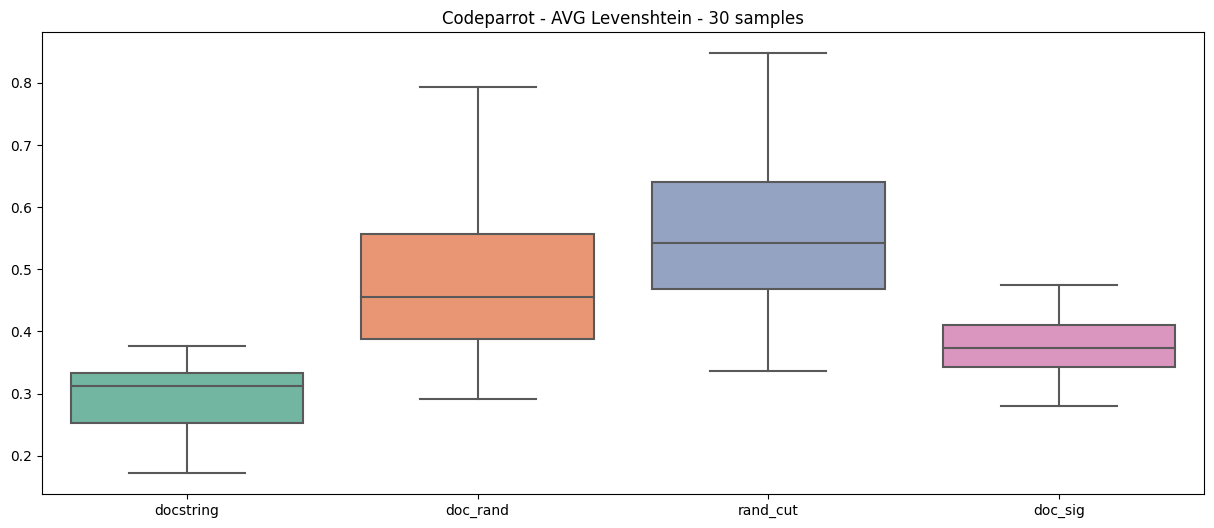

In [44]:
plt.figure(figsize=(15, 6)) 
sns.boxplot(data=lev_means, showfliers=False,palette="Set2").set_title("Codeparrot - AVG Levenshtein - 30 samples")

In [45]:
save_path= "/workspaces/code-rationales/datax/evaluation/"

In [47]:
    # Save the dataframe to a Parquet file
lev_df.to_parquet(save_path+'code_completion_docstring_5k_30_150_tokens.parquet')

In [48]:
lev_rand_code_df.to_parquet(save_path+'code_completion_random_cut_5k_30_512_tokens.parquet')

In [49]:
lev_signature_df.to_parquet(save_path+'code_completion_docstring_signature_3.8k_30_150_tokens.parquet')

In [50]:
lev_rand_df.to_parquet(save_path+'code_completion_docstring_random_cut_3.8k_30_150_tokens.parquet')